In [1]:
import os
import torch
from torch import nn
from torch import optim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime

In [2]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=16, num_layers=1, batch_first=True)
        for p in self.rnn.parameters():
            nn.init.normal_(p, mean=0.0, std=0.001)
        self.linear = nn.Linear(in_features=16, out_features=1)

    def forward(self, x, hidden_prev):
        out, hidden_prev = self.rnn(x, hidden_prev)
        out = out.view(-1, 16)
        out = self.linear(out)
        out = out.unsqueeze(dim=0)
        return out, hidden_prev

In [3]:
LINK_2727_PATH = "../data/MELBOURNE CITY/1005110000-1005230000/raw/2727.csv"

In [4]:
df_2727 = pd.read_csv(LINK_2727_PATH)

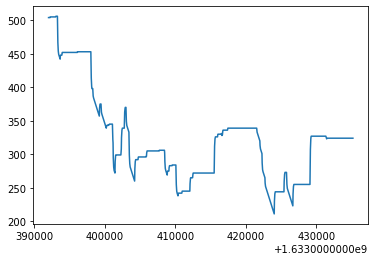

In [5]:
time_stamp = df_2727['TIMESTAMP'].values
travel_time = df_2727['TRAVEL_TIME'].values
plt.plot(time_stamp, travel_time)
plt.show()

In [6]:
df_2727.head(5)

,ID,TRAVEL_TIME,DENSITY,TIMESTAMP
0,2727,504,895,1633392000
1,2727,504,925,1633392030
2,2727,504,955,1633392060
3,2727,504,985,1633392090
4,2727,504,1015,1633392120


In [7]:
num_time_steps = 50
x = []
y_true = []
for i in range(0, len(travel_time)):
    if i+num_time_steps+1 > len(travel_time):
        break
    x.append(travel_time[i:i+num_time_steps])
    y_true.append(travel_time[i+1:i+num_time_steps+1])

In [8]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
x = s.fit_transform(x)

In [9]:
x = torch.tensor(x).float().view(len(x), 1, num_time_steps, 1)
y = torch.tensor(y_true).float().view(len(y_true), 1, num_time_steps, 1)

In [10]:
print(x.shape)

torch.Size([1390, 1, 50, 1])


In [11]:
model = RNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
hidden_prev = torch.zeros(1, 1, 16)
for iter in range(100):
    for i in range(x.shape[0]):
        output, hidden_prev = model(x[i], hidden_prev)
        hidden_prev = hidden_prev.detach()
        loss = criterion(output, y[i])
        model.zero_grad()
        loss.backward()
        optimizer.step()
    if iter % 10 == 0:
        print("iteration: {} loss {}".format(iter, loss.item()))

iteration: 0 loss 23235.357421875
iteration: 10 loss 0.904041588306427
iteration: 20 loss 0.1785103976726532
iteration: 30 loss 0.035623494535684586
iteration: 40 loss 0.2792937457561493
iteration: 50 loss 0.5897330641746521
iteration: 60 loss 0.18973277509212494
iteration: 70 loss 0.025838211178779602
iteration: 80 loss 0.01918591931462288
iteration: 90 loss 0.022501878440380096


In [12]:
preds = []
for i in range(x.shape[0]):
    output, hidden_prev = model(x[i], hidden_prev)
    preds.append(output.detach().numpy().ravel()[-1])
    
    

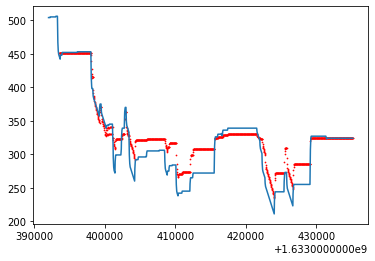

In [13]:
time_stamp_pred = [time_stamp[i+num_time_steps] for i in range(len(time_stamp)) if i + num_time_steps < len(time_stamp)]

plt.plot(time_stamp, travel_time)
plt.scatter(time_stamp_pred, preds, color='red', s=0.5)
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error
y_true_2 = [i[-1] for i in y_true]
print(mean_squared_error(y_true=y_true_2, y_pred=preds))

443.5915527566376
